In [46]:
import numpy as np
import pandas as pd

In [47]:
import matplotlib.pyplot as plt

plt.rc('font', size=14)
plt.rc('axes', labelsize=14, titlesize=14)
plt.rc('legend', fontsize=14)
plt.rc('xtick', labelsize=10)
plt.rc('ytick', labelsize=10)

In [48]:
class1_ls = pd.read_csv("Group15/LS_Group15/Class1.txt", sep=' ', header=None)
class2_ls = pd.read_csv("Group15/LS_Group15/Class2.txt", sep=' ', header=None)
class3_ls = pd.read_csv("Group15/LS_Group15/Class3.txt", sep=' ', header=None)

In [49]:
class1_ls.head()

,0,1
0,-2.2365,2.3224
1,2.4445,4.5807
2,1.8720,1.1315
3,5.1338,1.0316
4,2.1731,2.2868


In [50]:
class1_ls = class1_ls.assign(Class=1)
class2_ls = class2_ls.assign(Class=2)
class3_ls = class3_ls.assign(Class=3)

In [51]:
class1_ls.head()

,0,1,Class
0,-2.2365,2.3224,1
1,2.4445,4.5807,1
2,1.8720,1.1315,1
3,5.1338,1.0316,1
4,2.1731,2.2868,1


In [52]:
df = pd.concat([class1_ls, class2_ls, class3_ls], ignore_index=True)
df

,0,1,Class
0,-2.2365,2.3224,1
1,2.4445,4.5807,1
2,1.8720,1.1315,1
3,5.1338,1.0316,1
4,2.1731,2.2868,1
...,...,...,...
1495,17.1120,-6.9613,3
1496,16.8170,-2.7400,3
1497,14.7910,-3.5821,3
1498,17.1720,-9.3333,3


In [53]:
from sklearn.model_selection import train_test_split

X, y = df.drop('Class', axis=1), df['Class']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, shuffle=True, random_state=42)

In [54]:
X_train.head()

,0,1
485,1.95100,2.7375
527,5.36860,-10.9920
199,0.91329,2.4156
889,6.78260,-11.8090
844,6.71020,-14.3710


# Bayes Classifier 1:
Covariance matrix for all the classes is the same and is $\sigma^2 I$ 

In [55]:
class BayesClassifier1:
    def __init__(self):
        pass

    def __find_rep_temp(self, df_train):
        class_variances = df_train.groupby('Class').var()
        avg_var = class_variances.mean(axis=0)

        self.M = df_train['Class'].nunique()

        self.cov_mat = np.zeros((len(avg_var), len(avg_var)))
        for i in range(len(avg_var)):
            self.cov_mat[i][i] = avg_var[i]
        
        self.means = df_train.groupby('Class').mean()

        self.priors = df_train['Class'].value_counts() / len(df_train)

    def fit(self, X_train, y_train):
        df_train = pd.concat([X_train, y_train], axis=1)
        df_train = df_train.reset_index(drop=True)
    
        # finds the sigma and the mus
        self.__find_rep_temp(df_train)

    def __discriminant(self, x, mu, prior):
        return -1/2 * (np.transpose(x - mu) @ np.linalg.inv(self.cov_mat) @ (x - mu)) + np.log(prior)

    def predict(self, X_test):
        y_pred = []

        for idx in range(len(X_test)):
            x = X_test.iloc[idx]
            gs = []

            for i in range(self.M):
                gs.append(self.__discriminant(x, self.means.iloc[i], self.priors.iloc[i]))
        
            y_pred.append(np.argmax(gs) + 1)

        return y_pred

In [56]:
def plot_boundaries(classifier, X_test, y_test):
    x_min, x_max = X_test.iloc[:, 0].min() - 1, X_test.iloc[:, 0].max() + 1
    y_min, y_max = X_test.iloc[:, 1].min() - 1, X_test.iloc[:, 1].max() + 1

    xx, yy = np.meshgrid(np.arange(x_min, x_max, 0.1), np.arange(y_min, y_max, 0.1))

    Z = np.array(classifier.predict(pd.DataFrame(np.c_[xx.ravel(), yy.ravel()])))
    Z = Z.reshape(xx.shape)

    plt.contourf(xx, yy, Z, alpha=0.3)

    for class_label in classifier.means.index:
        plt.scatter(
            X_test[y_test == class_label].iloc[:, 0],
            X_test[y_test == class_label].iloc[:, 1],
            label=f"Class {class_label}",
            edgecolors='k'
        )
    
    plt.xlabel('Feature 1')
    plt.ylabel('Feature 2')
    plt.title('Decision Boundaries and Test Data')
    plt.legend()
    plt.show()

In [60]:
def confusion_mat(y_pred, y_test):
    M = np.unique(y_test).size

    conf_mat = np.zeros((M, M))

    for i in range(len(y_test)):
        conf_mat[y_pred[i]-1][y_test[i]-1] += 1
    
    return conf_mat

def classification_accuracy(y_pred, y_test):
    M = np.unique(y_test).size

    tp_tn = 0

    for i in range(len(y_test)):
        if y_pred[i] == y_test[i]:
            tp_tn += 1
    
    return tp_tn / len(y_pred)

def precision(y_pred, y_test, target_class):
    tp = 0
    fp =0

    for i in range(len(y_test)):
        if y_pred[i] == target_class and y_test[i] == target_class:
            tp += 1
        elif y_pred[i] == target_class:
            fp += 1

    return tp / (tp + fp)

def recall(y_pred, y_test, target_class):
    tp = 0
    fn = 0

    for i in range(len(y_test)):
        if y_pred[i] == target_class and y_test[i] == target_class:
            tp += 1
        elif y_pred[i] != target_class and y_test[i] == target_class:
            fn += 1

    return tp / (tp + fn)

def f_score(y_pred, y_test, target_class):
    prec = precision(y_pred, y_test, target_class)
    rec = recall(y_pred, y_test, target_class)

    return 2 * prec * rec / (prec + rec)

In [63]:
bc1 = BayesClassifier1()
bc1.fit(X_train, y_train)

In [64]:
y_pred = bc1.predict(X_test)

In [66]:
confusion_mat(y_pred, np.array(y_test))

array([[147.,   0.,   0.],
       [  0., 141.,   1.],
       [  1.,   0., 160.]])

In [67]:
classification_accuracy(y_pred, np.array(y_test))

0.9955555555555555

In [77]:
precisions = []
recalls = []
f_scores = []

for i in range(1, 4):
    precisions.append(precision(y_pred, np.array(y_test), i))
    recalls.append(recall(y_pred, np.array(y_test), i))
    f_scores.append(f_score(y_pred, np.array(y_test), i))

In [78]:
mean_precision = np.sum(precisions) / len(precisions)
mean_precision

0.9955821887848831

In [79]:
mean_recall = np.sum(recalls) / len(recalls)
mean_recall

0.9956773543730065

In [80]:
mean_f_score = np.sum(f_scores) / len(f_scores)
mean_f_score

0.9956218068209027

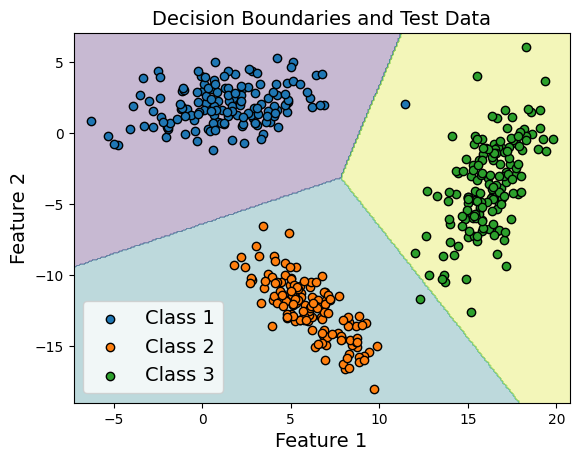

In [81]:
plot_boundaries(bc1, X_test, y_test)

# Bayes Classifier 2:
Full Covariance matrix for all the classes is the same and is $\Sigma$

In [98]:
class BayesClassifier2:
    def __init__(self):
        pass

    def __find_rep_temp(self, df_train):
        self.M = df_train['Class'].nunique()

        self.means = df_train.groupby('Class').mean()
        self.covariance = np.zeros((df_train.shape[1] - 1, df_train.shape[1] - 1))

        for class_label in range(1, self.M + 1):
            class_data = df_train[df_train['Class'] == class_label].iloc[:, :-1]
            class_covaraince = class_data.cov()

            self.covariance += class_covaraince.values
        
        self.covariance /= self.M

        self.priors = df_train['Class'].value_counts() / len(df_train)

    def fit(self, X_train, y_train):
        df_train = pd.concat([X_train, y_train], axis=1)
        df_train = df_train.reset_index(drop=True)

        self.__find_rep_temp(df_train)

    def __discriminant(self, x, mu, prior):
        return -1/2 * (np.transpose(x - mu) @ np.linalg.inv(self.covariance) @ (x - mu)) + np.log(prior)
    
    def predict(self, X_test):
        y_pred = []

        for idx in range(len(X_test)):
            x = X_test.iloc[idx]
            gs = []

            for i in range(self.M):
                gs.append(self.__discriminant(x, self.means.iloc[i], self.priors.iloc[i]))
            
            y_pred.append(np.argmax(gs) + 1)

        return y_pred

In [99]:
bc2 = BayesClassifier2()
bc2.fit(X_train, y_train)

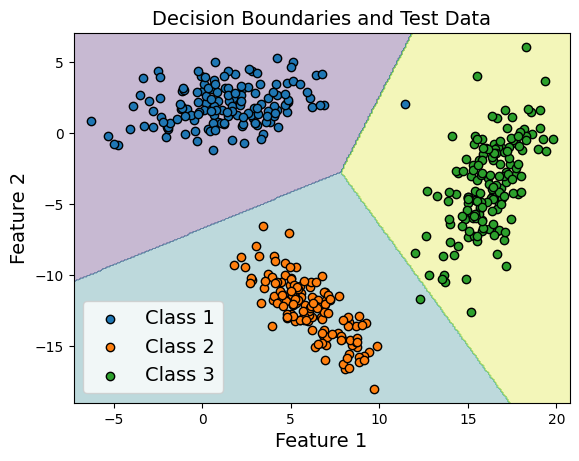

In [100]:
plot_boundaries(bc2, X_test, y_test)

# Bayes Classifier 2:
Covariance matrix is diagonal and different for each class

In [ ]:
class BayesClassifier3:
    def __init__(self):
        pass

    def __find_rep_temp(self, df_train):
        pass

    def fit(self, X_train, y_train):
        df_train = pd.concat([X_train, y_train], axis=1)
        df_train.reset_index(drop=True)

        self.__find_rep_temp(df_train)

    